<a href="https://colab.research.google.com/github/ShuqairABD/SARIMAX_Original_test_Graphic/blob/main/SARIMAX_Original_test_Graphic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

      Время Время создания/изменения  Глюкоза сенсора (ммоль/л)
0  0.003194      2019-01-11 00:04:00                       14.3
1  0.006667      2019-01-11 00:09:00                       14.4
2  0.010139      2019-01-11 00:14:00                       14.5
3  0.013611      2019-01-11 00:19:00                       14.8
4  0.017083      2019-01-11 00:24:00                       14.9


<ipython-input-1-66723cd3e87f>:27: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_5min = data.set_index('Datetime').resample('5T').mean().reset_index()


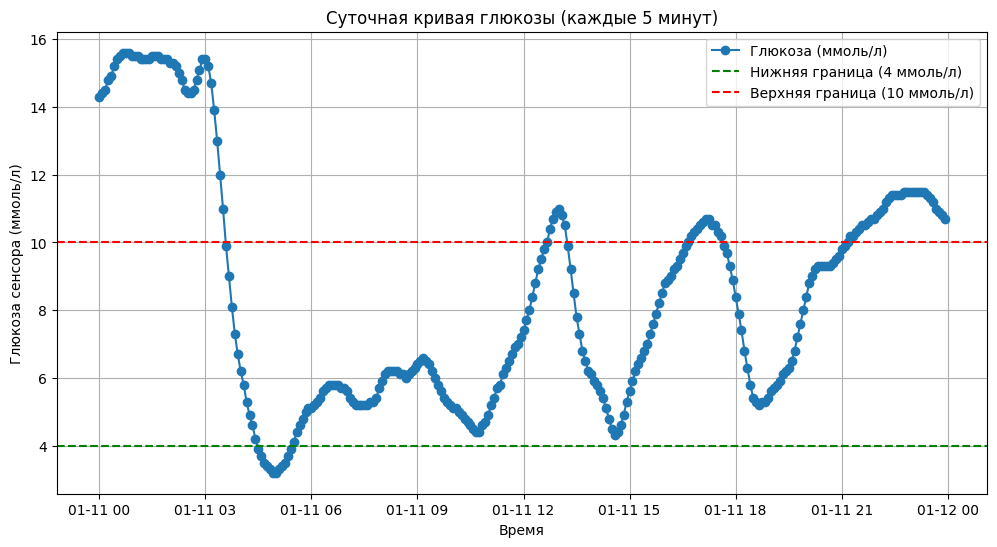

In [ ]:
file_path = '/content/Суточна НМГ.xlsx'

# read file
data = pd.read_excel(file_path)

print(data.head())

# Переименоват колонки
data.rename(columns={
    "Время": "Time",
    "Время создания/изменения": "Datetime",
    "Глюкоза сенсора (ммоль/л)": "Sensor Glucose"
}, inplace=True)

# времия в datetime
data['Datetime'] = pd.to_datetime(data['Datetime'])

# данные отсортированы по времени
data.sort_values('Datetime', inplace=True)

# Отборка данные с интервалом в 5 минут
data_5min = data.set_index('Datetime').resample('5T').mean().reset_index()

# график
plt.figure(figsize=(12, 6))
plt.plot(data_5min['Datetime'], data_5min['Sensor Glucose'], marker='o', label='Глюкоза (ммоль/л)')
plt.axhline(y=4, color='green', linestyle='--', label='Нижняя граница (4 ммоль/л)')
plt.axhline(y=10, color='red', linestyle='--', label='Верхняя граница (10 ммоль/л)')
plt.xlabel('Время')
plt.ylabel('Глюкоза сенсора (ммоль/л)')
plt.title('Суточная кривая глюкозы (каждые 5 минут)')
plt.legend()
plt.grid()
plt.show()


**данные за последние 24 часа**

<ipython-input-2-a93464802fdf>:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_5min_24h = data_last_24h.set_index('Datetime').resample('5T').mean().reset_index()


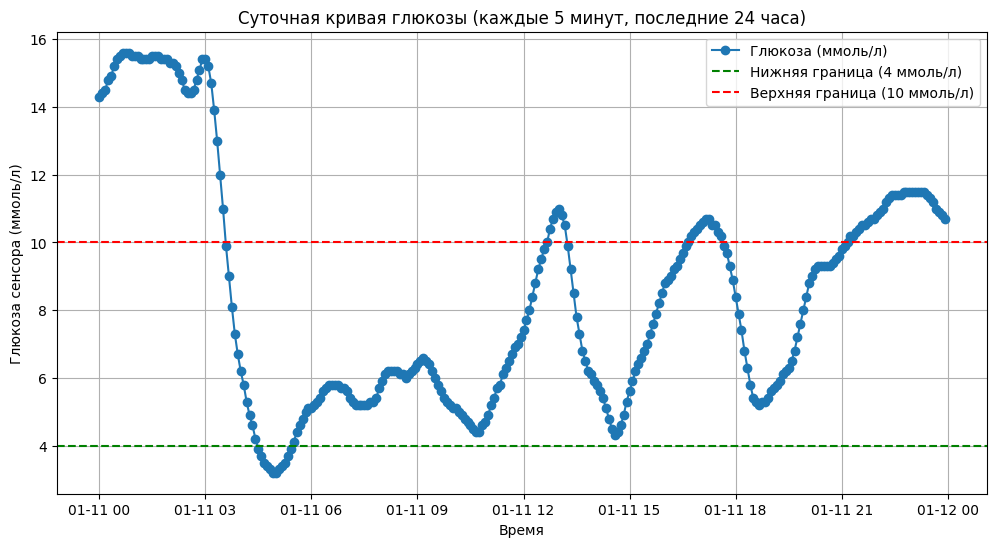

In [ ]:
# (текущая дата минус 1 день)
end_time = data['Datetime'].max()
start_time = end_time - pd.Timedelta(hours=24)

# Фильтрация данные за последние 24 часа
data_last_24h = data[(data['Datetime'] >= start_time) & (data['Datetime'] <= end_time)]

# Отборка данные с интервалом в 5 минут за последние 24 часа
data_5min_24h = data_last_24h.set_index('Datetime').resample('5T').mean().reset_index()

# график
plt.figure(figsize=(12, 6))
plt.plot(data_5min_24h['Datetime'], data_5min_24h['Sensor Glucose'], marker='o', label='Глюкоза (ммоль/л)')
plt.axhline(y=4, color='green', linestyle='--', label='Нижняя граница (4 ммоль/л)')
plt.axhline(y=10, color='red', linestyle='--', label='Верхняя граница (10 ммоль/л)')
plt.xlabel('Время')
plt.ylabel('Глюкоза сенсора (ммоль/л)')
plt.title('Суточная кривая глюкозы (каждые 5 минут, последние 24 часа)')
plt.legend()
plt.grid()
plt.show()


In [ ]:
def generate_recommendations(data):
    last_value = data['Sensor Glucose'].iloc[-1]  # Последнее значение глюкозы
    recommendations = []

    if last_value < 4:
        recommendations.append("Гипогликемия! Необходимо срочно принять быстрые углеводы (например, сладкий напиток).")
    elif 4 <= last_value <= 10:
        recommendations.append("Уровень глюкозы в норме. Продолжайте соблюдать текущую терапию.")
    elif last_value > 10:
        recommendations.append("Гипергликемия! Рекомендуется проверка дозы инсулина или физическая активность.")

    # Проверка тренда глюкозы
    if len(data) >= 6:  # 6 точек = последние 30 минут (если данные каждые 5 минут)
        trend = data['Sensor Glucose'].iloc[-6:].diff().mean()
        if trend > 0.5:  # Глюкоза растет слишком быстро
            recommendations.append("Глюкоза быстро растет. Возможна гипергликемия через 30 минут.")
        elif trend < -0.5:  # Глюкоза падает слишком быстро
            recommendations.append("Глюкоза быстро падает. Возможна гипогликемия через 30 минут.")

    return recommendations

# Генерация рекомендаций
recommendations = generate_recommendations(data_5min_24h)
print("Рекомендации:")
for rec in recommendations:
    print("- ", rec)


Рекомендации:
-  Гипергликемия! Рекомендуется проверка дозы инсулина или физическая активность.


**SARIMAX**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [ ]:
def generate_recommendations(data):
    # Последнее значение глюкозы
    last_value = data['Sensor Glucose'].iloc[-1]
    recommendations = []

    # Гипогликемия (меньше 3 ммоль/л)
    if last_value < 3:
        recommendations.append("⚠️ Уровень глюкозы: {:.2f} ммоль/л. Это гипогликемия! Срочно примите быстрые углеводы (сладкий напиток, конфеты).".format(last_value))
        recommendations.append("❗️ Проверьте уровень глюкозы через 15 минут.")

    # Норма (между 3 и 10 ммоль/л)
    elif 3 <= last_value <= 10:
        recommendations.append("✅ Уровень глюкозы: {:.2f} ммоль/л. Это норма.".format(last_value))

        # Дополнительные рекомендации
        if last_value > 8:
            recommendations.append("🔶 Уровень ближе к верхней границе. Рекомендуется следить за питанием и активностью.")
        elif last_value < 4.5:
            recommendations.append("🔶 Уровень ближе к нижней границе. Будьте внимательны, возможна гипогликемия.")
        else:
            recommendations.append("👌 Продолжайте соблюдать текущую терапию.")

    # Гипергликемия (больше 10 ммоль/л)
    elif last_value > 10:
        recommendations.append("⚠️ Уровень глюкозы: {:.2f} ммоль/л. Это гипергликемия!".format(last_value))
        recommendations.append("❗️ Рекомендуется физическая активность (например, прогулка) или проверка дозы инсулина.")
        recommendations.append("🩺 Если уровень продолжает расти, обратитесь к врачу.")

    return recommendations

# Пример использования:
recommendations = generate_recommendations(data_5min_24h)

# рекомендаций
print("Рекомендации:")
for rec in recommendations:
    print("- ", rec)


Рекомендации:
-  ⚠️ Уровень глюкозы: 10.70 ммоль/л. Это гипергликемия!
-  ❗️ Рекомендуется физическая активность (например, прогулка) или проверка дозы инсулина.
-  🩺 Если уровень продолжает расти, обратитесь к врачу.


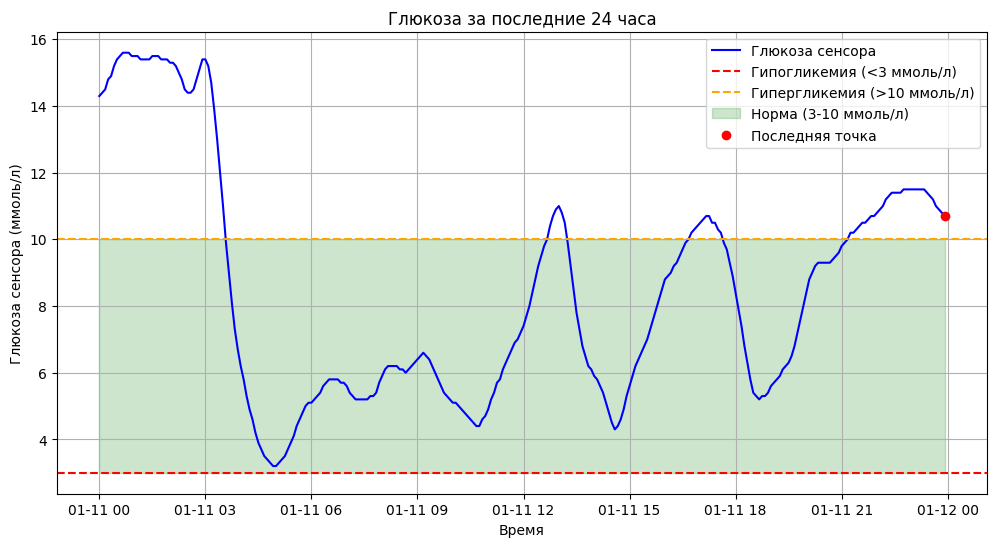

In [ ]:
# Визуализация с рекомендациями
plt.figure(figsize=(12, 6))
plt.plot(data_5min_24h['Datetime'], data_5min_24h['Sensor Glucose'], label="Глюкоза сенсора", color='blue')
plt.axhline(y=3, color='red', linestyle='--', label='Гипогликемия (<3 ммоль/л)')
plt.axhline(y=10, color='orange', linestyle='--', label='Гипергликемия (>10 ммоль/л)')
plt.fill_between(data_5min_24h['Datetime'], 3, 10, color='green', alpha=0.2, label='Норма (3-10 ммоль/л)')
plt.scatter(data_5min_24h['Datetime'].iloc[-1], data_5min_24h['Sensor Glucose'].iloc[-1], color='red', label="Последняя точка", zorder=5)

plt.xlabel("Время")
plt.ylabel("Глюкоза сенсора (ммоль/л)")
plt.title("Глюкоза за последние 24 часа")
plt.legend()
plt.grid()
plt.show()


<ipython-input-8-2c1144666d09>:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_5min_24h['Sensor Glucose'] = data_5min_24h['Sensor Glucose'].fillna(method='ffill')
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Средняя абсолютная ошибка (MAE): 0.13 ммоль/л


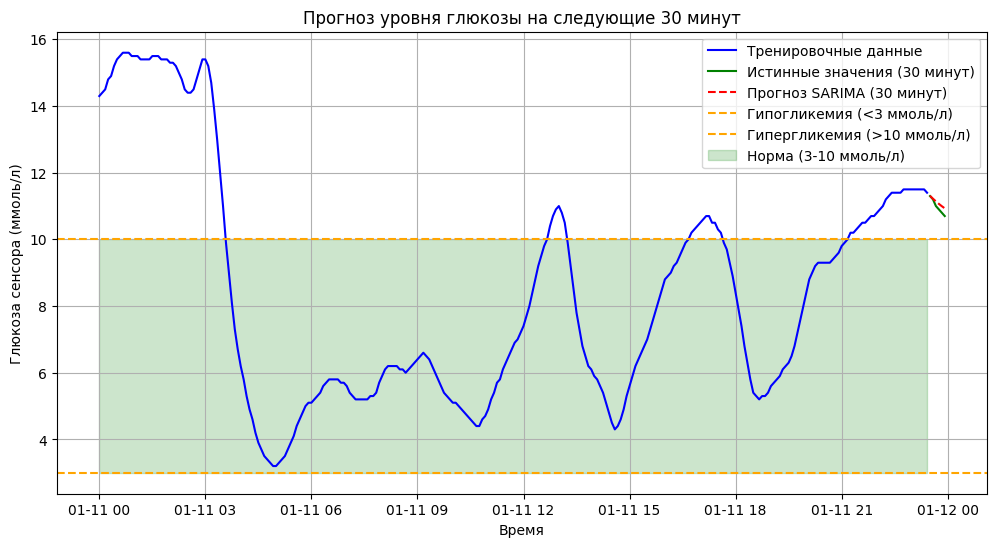

⚠️ Прогноз: Уровень глюкозы через 30 минут составит 10.93 ммоль/л. Риск гипергликемии!


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Подготовка данных для временного ряда
# данные отсортированы по времени
data_5min_24h = data_5min_24h.sort_values(by='Datetime')

# Убирать пропуски
data_5min_24h['Sensor Glucose'] = data_5min_24h['Sensor Glucose'].fillna(method='ffill')

# Устанавливать временной индекс
data_5min_24h = data_5min_24h.set_index('Datetime')

# Train / Test
train = data_5min_24h[:-6]  # 30 минут назад (6 точек, каждая по 5 минут)
test = data_5min_24h[-6:]  # 30 минут вперед

#  Настройка модели SARIMA
# SARIMA(p, d, q)(P, D, Q, s)
# p, d, q - параметры ARIMA
# P, D, Q, s - сезонные параметры
model = SARIMAX(train['Sensor Glucose'],
                order=(1, 1, 1),  # ARIMA параметры
                seasonal_order=(1, 0, 0, 288),  # 288 точек = 24 часа (5 мин каждая)
                enforce_stationarity=False,
                enforce_invertibility=False)

sarima_model = model.fit(disp=False)

#Прогноз на следующие 6 точек (30 минут)
forecast = sarima_model.forecast(steps=6)

# Шаг 5: Оценка модели
mae = mean_absolute_error(test['Sensor Glucose'], forecast)
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f} ммоль/л")

# Шаг 6: Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sensor Glucose'], label="Тренировочные данные", color='blue')
plt.plot(test.index, test['Sensor Glucose'], label="Истинные значения (30 минут)", color='green')
plt.plot(test.index, forecast, label="Прогноз SARIMA (30 минут)", color='red', linestyle='--')
plt.axhline(y=3, color='orange', linestyle='--', label='Гипогликемия (<3 ммоль/л)')
plt.axhline(y=10, color='orange', linestyle='--', label='Гипергликемия (>10 ммоль/л)')
plt.fill_between(train.index, 3, 10, color='green', alpha=0.2, label='Норма (3-10 ммоль/л)')
plt.xlabel("Время")
plt.ylabel("Глюкоза сенсора (ммоль/л)")
plt.title("Прогноз уровня глюкозы на следующие 30 минут")
plt.legend()
plt.grid()
plt.show()

#  рекомендаций
last_forecast_value = forecast.iloc[-1]
if last_forecast_value < 3:
    print("⚠️ Прогноз: Уровень глюкозы через 30 минут составит {:.2f} ммоль/л. Риск гипогликемии!".format(last_forecast_value))
elif last_forecast_value > 10:
    print("⚠️ Прогноз: Уровень глюкозы через 30 минут составит {:.2f} ммоль/л. Риск гипергликемии!".format(last_forecast_value))
else:
    print("✅ Прогноз: Уровень глюкозы через 30 минут составит {:.2f} ммоль/л. Ожидается нормальный уровень.".format(last_forecast_value))
